In [35]:
import findspark
from functools import reduce
from pyspark import SparkContext
from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
import plotly as py
import matplotlib.pyplot as plt

In [51]:
#connecting to a spark cluster
# sc = SparkContext("local", "firstSpark")

In [2]:
#https://spark.apache.org/docs/latest/sql-getting-started.html
spark = SparkSession \
        .builder \
        .appName("firstSpark") \
        .getOrCreate()

In [53]:
# help(SparkContext)

In [54]:
# help(spark.read.format)

In [55]:
# spark.read.format('csv').options

In [3]:
# df = spark.read.format('csv').options(header='true').load(".")
def load_dataframe(filename):
    df = spark.read.format('csv').options(header='true').load(filename)
    return df

In [4]:
#creating a dataframe
df_matches = load_dataframe('./Data/Matches.csv')
df_matches.limit(5).show()

+--------+---+------+----------+-------------+--------------+----+----+---+
|Match_ID|Div|Season|      Date|     HomeTeam|      AwayTeam|FTHG|FTAG|FTR|
+--------+---+------+----------+-------------+--------------+----+----+---+
|       1| D2|  2009|2010-04-04|   Oberhausen|Kaiserslautern|   2|   1|  H|
|       2| D2|  2009|2009-11-01|  Munich 1860|Kaiserslautern|   0|   1|  A|
|       3| D2|  2009|2009-10-04|Frankfurt FSV|Kaiserslautern|   1|   1|  D|
|       4| D2|  2009|2010-02-21|Frankfurt FSV|     Karlsruhe|   2|   1|  H|
|       5| D2|  2009|2009-12-06|        Ahlen|     Karlsruhe|   1|   3|  A|
+--------+---+------+----------+-------------+--------------+----+----+---+



In [5]:
#converting to pandas dataframe
df_matches.limit(5).toPandas()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A


In [118]:
#matches.printSchema()

In [6]:
#lets rename some of the columns
old_cols = df_matches.columns[-3:]
new_cols = ["HomeTeamGoals", "AwayTeamGoals", "FinalResult"]
old_new_cols = [*zip(old_cols, new_cols)]
for old_col, new_col in old_new_cols:
    df_matches = df_matches.withColumnRenamed(old_col, new_col)

In [7]:
df_matches.limit(5).toPandas()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,HomeTeamGoals,AwayTeamGoals,FinalResult
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A


In [62]:
#finding the null count in each column
# matches.select([count(when(isnan(column), column)).alias(column) for column in matches.columns]).show()
# [df_matches.filter(col(column).isNull()).count() for column in df_matches.columns]

In [ ]:
#Comparing it to Pandas
# matches.toPandas().isnull().sum()

### Who are the winners Bundesliga in the last decade?

In [140]:
#lets encode FinalResult
df_matches.limit(5).toPandas()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,HomeTeamGoals,AwayTeamGoals,FinalResult,HomeTeamWin,AwayTeamWin,GameTie
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H,1,0,0
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A,0,1,0
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D,0,0,1
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H,1,0,0
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A,0,1,0


In [8]:
df_matches = df_matches.withColumn('HomeTeamWin', when(col('FinalResult') == 'H', 1).otherwise(0)) \
                        .withColumn('AwayTeamWin', when(col('FinalResult') == 'A', 1).otherwise(0)) \
                        .withColumn('GameTie', when(col('FinalResult') == 'D', 1).otherwise(0))


#bundesliga is a D1 division and we are interested in season <= 2010 and >= 2000
bundesliga = df_matches \
                    .filter((col('Season') >= 2000) & 
                            (col('Season') <= 2010) & 
                            (col('Div') == 'D1'))

# home team features
home = bundesliga.groupby('Season', 'HomeTeam') \
       .agg(sum('HomeTeamWin').alias('TotalHomeWin'),
            sum('AwayTeamWin').alias('TotalHomeLoss'),
            sum('GameTie').alias('TotalHomeTie'),
            sum('HomeTeamGoals').alias('HomeScoredGoals'),
            sum('AwayTeamGoals').alias('HomeAgainstGoals')) \
       .withColumnRenamed('HomeTeam', 'Team')

#away game features 
away =  bundesliga.groupby('Season', 'AwayTeam') \
       .agg(sum('AwayTeamWin').alias('TotalAwayWin'),
            sum('HomeTeamWin').alias('TotalAwayLoss'),
            sum('GameTie').alias('TotalAwayTie'),
            sum('AwayTeamGoals').alias('AwayScoredGoals'),
            sum('HomeTeamGoals').alias('AwayAgainstGoals'))  \
       .withColumnRenamed('AwayTeam', 'Team')

#season features
window = ['Season']
window = Window.partitionBy(window).orderBy(col('WinPct').desc(), col('GoalDifferentials').desc())
table = home.join(away, ['Team', 'Season'],  'inner') \
    .withColumn('GoalsScored', col('HomeScoredGoals') + col('AwayScoredGoals')) \
    .withColumn('GoalsAgainst', col('HomeAgainstGoals') + col('AwayAgainstGoals')) \
    .withColumn('GoalDifferentials', col('GoalsScored') - col('GoalsAgainst')) \
    .withColumn('Win', col('TotalHomeWin') + col('TotalAwayWin')) \
    .withColumn('Loss', col('TotalHomeLoss') + col('TotalAwayLoss')) \
    .withColumn('Tie', col('TotalHomeTie') + col('TotalAwayTie')) \
    .withColumn('WinPct', round((100* col('Win')/(col('Win') + col('Loss') + col('Tie'))), 2)) \
    .drop('HomeScoredGoals', 'AwayScoredGoals', 'HomeAgainstGoals', 'AwayAgainstGoals') \
    .drop('TotalHomeWin', 'TotalAwayWin', 'TotalHomeLoss', 'TotalAwayLoss', 'TotalHomeTie', 'TotalAwayTie') \
    .withColumn('TeamPosition', rank().over(window)) 

table_df = table.filter(col('TeamPosition') == 1).orderBy(asc('Season')).toPandas()
table_df

,Team,Season,GoalsScored,GoalsAgainst,GoalDifferentials,Win,Loss,Tie,WinPct,TeamPosition
0,Bayern Munich,2000,62.0,37.0,25.0,19,9,6,55.88,1
1,Leverkusen,2001,77.0,38.0,39.0,21,7,6,61.76,1
2,Bayern Munich,2002,70.0,25.0,45.0,23,5,6,67.65,1
3,Werder Bremen,2003,79.0,38.0,41.0,22,4,8,64.71,1
4,Bayern Munich,2004,75.0,33.0,42.0,24,5,5,70.59,1
5,Bayern Munich,2005,67.0,32.0,35.0,22,3,9,64.71,1
6,Stuttgart,2006,61.0,37.0,24.0,21,6,7,61.76,1
7,Bayern Munich,2007,68.0,21.0,47.0,22,2,10,64.71,1
8,Wolfsburg,2008,80.0,41.0,39.0,21,7,6,61.76,1
9,Bayern Munich,2009,72.0,31.0,41.0,20,4,10,58.82,1


* Bayern Munich was destroying teams in the 2000s especially in 2004!

In [360]:
# window = Window.partitionBy('Team').orderby('WinPct')
table.groupby('Team').agg(count('Team').alias("TotalChampionships"),
                          avg('WinPct').alias('AvgWinPct'),
                          avg('GoalDifferentials').alias('AvgGD'),
                          avg('Win').alias('AvgWin'),
                          avg('Loss').alias('AvgLoss'),
                          avg('Tie').alias('AvgTie')) \
    .orderBy(desc("TotalChampionships")).toPandas().round(1)

,Team,TotalChampionships,AvgWinPct,AvgGD,AvgWin,AvgLoss,AvgTie
0,Bayern Munich,6,63.7,39.2,21.7,4.7,7.7
1,Werder Bremen,1,64.7,41.0,22.0,4.0,8.0
2,Leverkusen,1,61.8,39.0,21.0,7.0,6.0
3,Wolfsburg,1,61.8,39.0,21.0,7.0,6.0
4,Stuttgart,1,61.8,24.0,21.0,6.0,7.0
5,Dortmund,1,67.6,45.0,23.0,5.0,6.0


* Look at that!! Winning 6 times in the 2000s.
* Dortmund had one excellent season durin the same period. 

In [10]:
df_teams = load_dataframe('./Data/Teams.csv')
df_teams.limit(5).toPandas()

,Season,TeamName,KaderHome,AvgAgeHome,ForeignPlayersHome,OverallMarketValueHome,AvgMarketValueHome,StadiumCapacity
0,2017,Bayern Munich,27,26,15,597950000,22150000,75000
1,2017,Dortmund,33,25,18,416730000,12630000,81359
2,2017,Leverkusen,31,24,15,222600000,7180000,30210
3,2017,RB Leipzig,30,23,15,180130000,6000000,42959
4,2017,Schalke 04,29,24,17,179550000,6190000,62271


#### Which teams have been relegated in the past 2000 - 2010 years?

In [365]:
# lets check for 2000s
relegated = table.filter((col('TeamPosition') == 16) | 
             (col('TeamPosition') == 17) |
             (col('TeamPosition') == 18)).orderBy(asc('Season')) 
relegated.filter(col('Season') == 2000).toPandas()

,Team,Season,GoalsScored,GoalsAgainst,GoalDifferentials,Win,Loss,Tie,WinPct,TeamPosition
0,Stuttgart,2000,42.0,49.0,-7.0,9,14,11,26.47,16
1,Unterhaching,2000,35.0,59.0,-24.0,8,15,11,23.53,17
2,Bochum,2000,30.0,67.0,-37.0,7,21,6,20.59,18


### Does Oktoberfest have any effect on the performance of the overall league?

In [12]:
df_matches.limit(5).toPandas()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,HomeTeamGoals,AwayTeamGoals,FinalResult,HomeTeamWin,AwayTeamWin,GameTie
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H,1,0,0
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A,0,1,0
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D,0,0,1
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H,1,0,0
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A,0,1,0


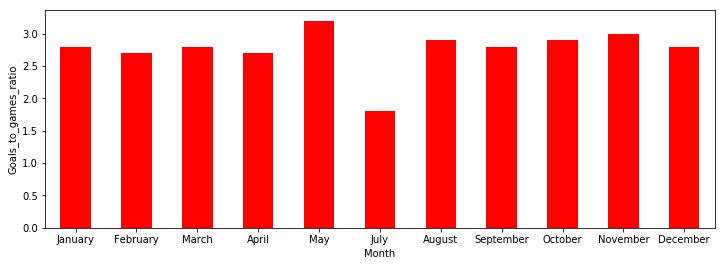

In [55]:
oktoberfest = df_matches \
                .filter(col('Div') == 'D1') \
                .filter((col('Season') >= 2000) &(col('Season') <= 2010)) \
                .withColumn('Month', month(col('Date'))) \
                .groupby('Month') \
                .agg(sum(col('HomeTeamGoals') + col('AwayTeamGoals')).alias('Goals'),
                     sum('GameTie').alias('GameTie'),
                     count(col('FinalResult')).alias('Total')) \
                .withColumn('Goals_to_games_ratio', round(col('Goals')/col('Total'), 1)) \
                .withColumn('GameTie_to_games_ratio', round(col('GameTie')/col('Total'), 1))

oktoberfest_df = oktoberfest.toPandas()

oktoberfest_df = oktoberfest_df.sort_values('Month')
oktoberfest_df['Month'] = [calendar.month_name[val] for val in oktoberfest_df.Month.tolist()]
oktoberfest_df.set_index('Month', drop=True, inplace=True)
oktoberfest_df['Goals_to_games_ratio'].plot.bar(rot=0, color='red', figsize=(12, 4))
plt.ylabel('Goals_to_games_ratio')
plt.show()

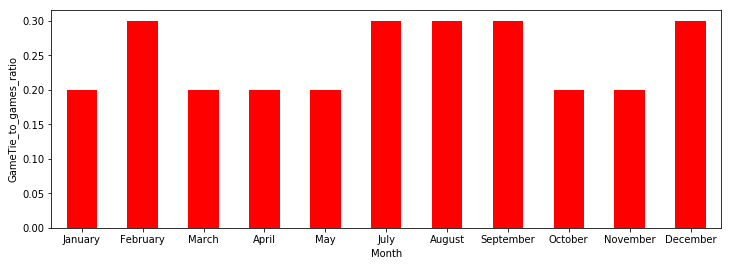

In [56]:
oktoberfest_df['GameTie_to_games_ratio'].plot.bar(rot=0, color='red', figsize=(12, 4))
plt.ylabel('GameTie_to_games_ratio')
plt.show()

#### Which season of Bundesliga was the most competitive in the last decade?

#### What's the best month to watch Bundesliga?